<a href="https://colab.research.google.com/github/nedokormysh/GB_intro_NN/blob/lesson8/GB_NN_intro_hw_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Построим вариационный автоэнкодер для датасета Fashion_MNIST. Для начала импортируем необходимые библиотеки.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Cоздадим слой семплирования.

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs # пакет, который приходит состоит из двух частей.
        batch = tf.shape(z_mean)[0] # количество примеров, которые приходят на вход
        dim = tf.shape(z_mean)[1] # размерность нашего скрытого пространства
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # создаём нормально распределённый набор случайных векторов в размере нашего пакета
        # каждому такому случайному вектору будет соответсвовать один семплированный пример.
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Создадим энкодер.

Воспользуемся энкодером и декодером со скрытым пространством размера 2.

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs) # 32 ядра размера 3, страйд = 2. Одновременно.
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

# Строим декодер.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) # выходное ядро с размером 1. Сигмоид, т.к. выход 1/0
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

# Создадим класс по Model c особым шагом обучения train_step.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Теперь обучим построенную модель VAE для изображений из датасета Fashion_MNIST.

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fashion_mnist_pics = np.concatenate([x_train, x_test], axis=0)
fashion_mnist_pics = np.expand_dims(fashion_mnist_pics, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_pics, epochs=20, batch_size=128)

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - 13s 9ms/step - loss: 322.1118 - reconstruction_loss: 317.0775 - kl_loss: 5.0343
Epoch 2/20
547/547 [==============================] - 5s 9ms/step - loss: 276.6036 - reconstruction_loss: 271.8240 - kl_loss: 4.7795
Epoch 3/20
547/547 [==============================] - 5s 9ms/step - loss: 272.4624 - reconstruction_loss: 267.9436 - kl_loss: 4.5187
Epoch 4/20
547/547 [==============================] - 5s 9ms/step - loss: 270.3198 - reconstruction_loss: 265.8952 - kl_loss: 4.4246
Epoch 5/20
547/547 [==============================] - 5s 9ms/step - loss: 269.0085 - reconstruction_loss: 264.6302 - kl_loss: 4.3783
Epoch 6/20
547/547 [==============================] - 5s 9ms/step - loss: 267.8630 - reconstruction_loss: 263.5120 - kl_loss: 4.3510
Epoch 7/20
547/547 [==============================] - 5s 9ms/step - loss: 266.8437 - reconstruction_loss: 262.5371 - kl_loss: 4.3066
Epoch

Лосс падает.

1/1 [==============================] - 0s 16ms/step


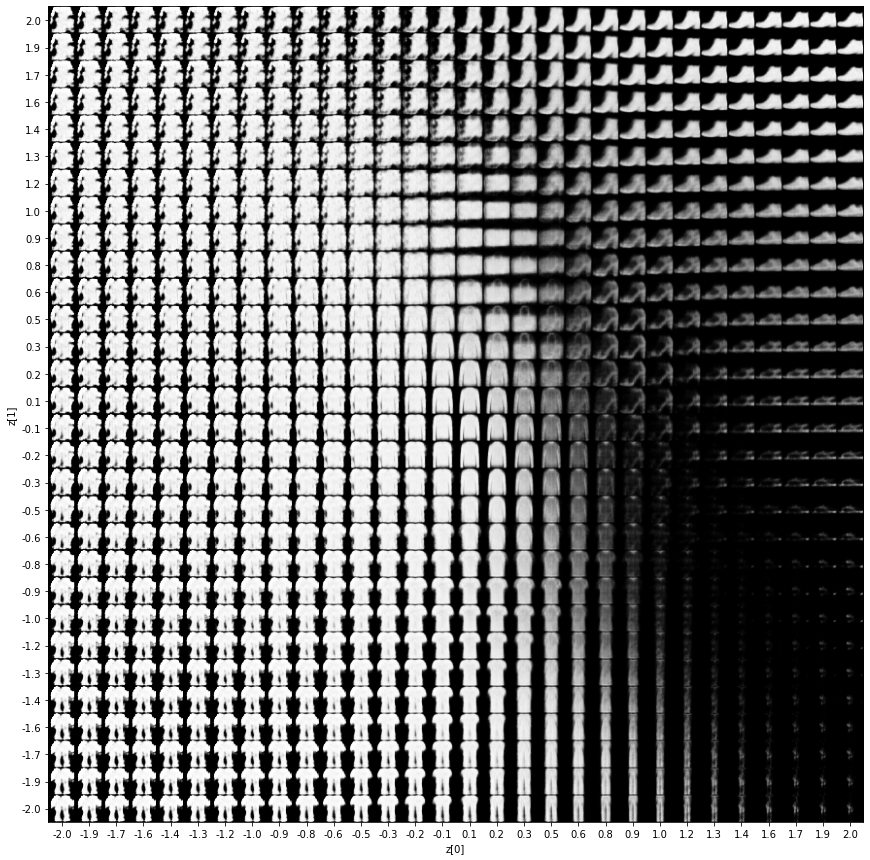

In [7]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((size * n, size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            pic = x_decoded[0].reshape(size, size)
            figure[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = pic

    plt.figure(figsize=(figsize, figsize))
    start_range = size // 2
    end_range = (n - 1) * size + start_range + 1
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

# Увеличим размер скрытого пространства.

In [8]:
latent_dim = 60

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   640         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 128)    73856       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 6272)         0           ['conv2d_3[0][0]']               
                                                                                            

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_3 (Dense)             (None, 6272)              382592    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        577 

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_pics, epochs=50, batch_size=32)

Epoch 1/50
2188/2188 [==============================] - 16s 7ms/step - loss: 239.4304 - reconstruction_loss: 237.1915 - kl_loss: 2.2389
Epoch 2/50
2188/2188 [==============================] - 15s 7ms/step - loss: 222.0717 - reconstruction_loss: 219.8504 - kl_loss: 2.2213
Epoch 3/50
2188/2188 [==============================] - 15s 7ms/step - loss: 219.8544 - reconstruction_loss: 217.6830 - kl_loss: 2.1714
Epoch 4/50
2014/2188 [==========================>...] - ETA: 1s - loss: 218.7234 - reconstruction_loss: 216.5988 - kl_loss: 2.1246

In [ ]:
def plot_latent_5D(encoder, decoder):
    n = 30
    size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((size * n, size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[1, 1, 0, xi, yi]])
            x_decoded = decoder.predict(z_sample)
            pic = x_decoded[0].reshape(size, size)
            figure[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = pic

    plt.figure(figsize=(figsize, figsize))
    start_range = size // 2
    end_range = (n - 1) * size + start_range + 1
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[3]")
    plt.ylabel("z[4]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_5D(encoder, decoder)